# Introduction

This project uses a 10,000 record subset of the [Million Songs Dataset](http://labrosa.ee.columbia.edu/millionsong/) , which is a collection of audio features and metadata for a million music tracks collected by The Echo Nest and LabROSA, as well as lyrics supplied by [musiXmatch](http://labrosa.ee.columbia.edu/millionsong/musixmatch). 

With a selection of variables from the above dataset, lyric-based clusters, and lyric-based sentiment analysis, we will attempt to predict the variable `artist_hotttnesss` using a nueral network. 

# Datasets
## Million Songs Subset

The [million songs subset](http://labrosa.ee.columbia.edu/millionsong/pages/getting-dataset#subset) provides 10,000 tracks in HDF5 file format, one file for each track which can be directly [downloaded](http://static.echonest.com/millionsongsubset_full.tar.gz) or found on the Million Songs website.

The features we want to include are as follows (though not all will be used, we may want to include additional features in further analysis):

* aritst_id: the Echo Nest artist ID
* artist_latitude: latitude
* artist_longitude: longitude
* artist_location: the location name
* song_id: the Echo Nest Song ID
* artist_name: Artist name
* title: Song title
* mode: major/minor
* mode_confidence: a confidence measure of the mode
* loudness: overall loudness in dB
* tempo: estimated tempo in BPM
* time_signature: estimated number of beats per bar
* time_signature_confidence: confidence measure of time signature
* key: the key the song is in
* key_confidence: confidence measure of the key
* track_id: Echo Nest track ID
* artist_hotttnesss: numerical description of how hot and artist currently is

Information about more variables can be found at http://labrosa.ee.columbia.edu/millionsong/pages/field-list.

In order to pull in these variables , we need to read each file and write the contents to a pandas Dataframe. We do that with the following code, available at [https://github.com/davidoury/MSD](https://github.com/davidoury/MSD).

### Libraries

In [31]:
import os
import re
import itertools as it
import pandas as pd
import numpy as np
import operator 
import functools

### Utility Functions

In [32]:
def get_filenames(path):
    return([get_filenames(path+"/"+entry.name)
            if entry.is_dir() 
            else path+"/"+entry.name 
            for entry 
            in os.scandir(path)
           ])

def unlist(alist):
    return(list(it.chain.from_iterable(alist)
               )
          )

def var_list(base,numof):
    return([base+str(ndx) for ndx in range(numof)]
          )

def h1d_array(in_array,n): 
    # n1d is the number of elements in `in_array`
    n1d = functools.reduce(operator.mul,
                           list(in_array.shape))
    # return a 1 row 2D array with `n` columns
    b = np.ndarray(shape=(1,n1d),
                   buffer=in_array,
                   dtype=in_array.dtype
                  )[0:1,0:n]
    return(b)

In [33]:
def make_1row_df(filename='', metadata_vars=[], analysis_vars=[], remove=False):
    # open `filename` as a HDF5 file
    store = pd.HDFStore(filename,"r")
    if remove==False:
        # lists `metadata_vars` and `analysis_vars` contain the variables to keep
        metadata_var_list = metadata_vars
        analysis_var_list = analysis_vars
    else: # these lists contain the variables to remove
        metadata_var_list = list({item for item 
                                  in list(store.root.metadata.songs.read().dtype.names) 
                                  if item not in metadata_remove})
        analysis_var_list = list({item for item 
                                  in list(store.root.analysis.songs.read().dtype.names) 
                                  if item not in analysis_remove})
    ret = pd.concat([
            # retrieve a single row dataframe from `/metadata/songs`
            pd.DataFrame(store.root.metadata.songs.read(), 
                         columns=metadata_var_list),
            # retrieve a single row dataframe from `/analysis/songs`
            pd.DataFrame(store.root.analysis.songs.read(), 
                         columns=analysis_var_list)
            ], 
            axis=1)
    # close the HDF5 file
    store.close()
    # return the merged dataframe
    return(ret)

In [34]:
path = "../Data/MillionSongSubset/data"
filenames = unlist(unlist(unlist(get_filenames(path))))

In [35]:
p = re.compile("\.h5$")
filenames = [filename for filename 
             in filenames if p.search(filename)]

In [36]:
mss_df_list = [make_1row_df(filename=filename,
                            metadata_vars=['artist_id','artist_latitude','artist_location',\
                                           'artist_longitude','song_id', 'artist_name', 'title','artist_hotttnesss'],
                            # Omit: genre
                            analysis_vars=['key','key_confidence',\
                                           'mode', 'mode_confidence',\
                                           'loudness', 'tempo', \
                                           'time_signature', 'time_signature_confidence',\
                                           'track_id'],
                            # Omit: danceability, energy
                            remove=False
                           )
                for filename in filenames[0:10000] # get data from all 10,000 files
              ]
len(mss_df_list), mss_df_list[0].shape

(10000, (1, 17))

In [37]:
project_df = pd.concat(mss_df_list,axis=0).reset_index(drop=True)

We look at the first three records and find they're as we expected.

In [38]:
project_df.head(3)

,artist_id,artist_latitude,artist_location,artist_longitude,song_id,artist_name,title,artist_hotttnesss,key,key_confidence,mode,mode_confidence,loudness,tempo,time_signature,time_signature_confidence,track_id
0,b'ARD7TVE1187B99BFB1',NaN,b'California - LA',NaN,b'SOMZWCG12A8C13C480',b'Casual',"b""I Didn't Mean To""",0.401998,1,0.736,0,0.636,-11.197,92.198,4,0.778,b'TRAAAAW128F429D538'
1,b'ARMJAGH1187FB546F3',35.14968,"b'Memphis, TN'",-90.04892,b'SOCIWDW12A8C13D406',b'The Box Tops',b'Soul Deep',0.417500,6,0.169,0,0.430,-9.843,121.274,4,0.384,b'TRAAABD128F429CF47'
2,b'ARKRRTF1187B9984DA',NaN,b'',NaN,b'SOXVLOJ12AB0189215',b'Sonora Santanera',b'Amor De Cabaret',0.343428,8,0.643,1,0.565,-9.689,100.070,1,0.000,b'TRAAADZ128F9348C2E'


We'll save `mss_df` to a *pickle* file.

In [39]:
save_load_path = '../Data/MillionSongSubset/data'
project_df.to_pickle(save_load_path+'/project_df.pkl')

##### VARIABLES

## musiXmatch Dataset

Next we need to pull the lyrics from musiXmatch. They lyrics are available as a sqlite database, [mxm_dataset.db](http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_dataset.db). Details about the lyrics dataset can be found at http://labrosa.ee.columbia.edu/millionsong/musixmatch#getting. We'll also need a primer about how to use sqlite databases from within python, and how to load the sqlite3 package. 


In [40]:
import sqlite3

### Create Connections/Query Database

We first need to create a connection to each of our database files. The connection path specifies the directory in which the downloaded files have been stored. We'll use the connection every time we query the database. 

In [41]:
conn_lyrics = sqlite3.connect('../Data/mxm_dataset.db')

After we've created connections, there are a couple of ways we can pull data from the databases:

1. We can use SQLite to create a cursor which then fetches records based on our query parameters. A cursor is a database object used to traverse records in a database. The .execute method creates a cursor and then calls the cursors execute method. It returns the results as a list.

2. We can use the pandas read_sql function. It returns the results as a pandas DataFrame object

First, we'll want to look at the database schema. We'll start off by querying the sqlite_master table from a single sqlite database file using a sqlite cursor. The sqlite_master table defines the schema for the database. We'll use that to get information about the database and create our first query. More information about the sqlite_master table can be found at https://www.sqlite.org/faq.html#q7

In [42]:
res = conn_lyrics.execute("SELECT * FROM sqlite_master WHERE type = 'table'")
schema1 = res.fetchall()
type(schema1), schema1

(list,
 [('table', 'words', 'words', 2, 'CREATE TABLE words (word TEXT PRIMARY KEY)'),
  ('table',
   'lyrics',
   'lyrics',
   4,
   'CREATE TABLE lyrics (track_id, mxm_tid INT, word TEXT, count INT, is_test INT, FOREIGN KEY(word) REFERENCES words(word))')])

We find two tables in the mxm_dataset, `words` and `lyrics`. We can also see the fields and data types of the columns. The words table contains a list of the top 5000 words of the set. The lyrics table has a row for each track, word, and count of that word. 

We want to create a dictionary entry for each track, with the track_id as the key and the expanded lyrics as the value. For example, if a word exists in a track five times, we want five copies of that word instead of just a single copy. We'll save the dictionary as a json file and use it to create our clusters later.

From the mxm_dataset.db, we want a list of unique tracks. We find lyrics for 237,662 tracks. We'll pare these down later to include only tracks that are common to both the lyrics database and the million song subset.

In [43]:
tracks = pd.read_sql("SELECT DISTINCT track_id FROM lyrics", con = conn_lyrics)
len(tracks) # 237662 tracks

237662

In [44]:
tracks.head()

,track_id
0,TRAAAAV128F421A322
1,TRAAABD128F429CF47
2,TRAAAED128E0783FAB
3,TRAAAEF128F4273421
4,TRAAAEW128F42930C0


Next, we'll use the project_df to restrict our lyric selection to those songs that are in both the lyrics database and the subset. 

We drop the first two characters (b'), and the last character('), from track_id, which are artifacts of the encoding process. We then turn it into a pandas dataframe.

In [45]:
track_id = []
track_id = project_df['track_id'].map(lambda x: str(x)[2:len(x)+2])
track_id =pd.DataFrame(track_id)

Next we merge the tracks that have lyrics available with the tracks in the subset. Since we're only interested in the tracks for which there are lyrics, we use an inner join, which uses an intersection of keys from both dataframes. To learn more about different types of merges: http://pandas.pydata.org/pandas-docs/stable/merging.html#brief-primer-on-merge-methods-relational-algebra . 

We find that there are 2350 such tracks.

In [46]:
df_tracks = track_id.merge(tracks, how='inner', on='track_id')
len(df_tracks)

2350

Next we use the tracks from the dataframe to pull the lyrics from the database.

In [47]:
# set this to the number of tracks you want to pull from db
num_tracks = len(df_tracks['track_id']) 
# intialize empty dictionary to store tracks and lyrics
my_dict = {}

for i in range(0,num_tracks): 
    # assign the value of the track at current index to current track
    current_track = df_tracks.track_id[i]

    # pull the lyrics for that track and store it in a list
    res = conn_lyrics.execute("SELECT word, count FROM lyrics WHERE track_id = ?", [current_track])
    results = res.fetchall()

    # multiply the word by the number of times it occurs for each word in list
    li = [(x[0] + ' ') * x[1] for x in results]
    
    # use this version to get a single copy of each word
    # li = [x[0]for x in results]

    # get rid of commas between words
    li = str(li).replace(',','')
    
    # get rid of quotes between words
    li = str(li).replace("'",'')
    
    # add track and lyrics to dictionary
    my_dict[current_track] = li

We verify the number of tracks processed.

In [48]:
len(my_dict)

2350

Finally, we save the data to a json file. Why json? A dictionary stores data in the same way json stores data, so it seemed appropriate to use. It's human readable. We can open a json file in notepad and see our data. It's also faster than a pickle file, as benchmarked [here](https://kovshenin.com/2010/pickle-vs-json-which-is-faster/) . 

In [49]:
# save to json file in same directory
import json
with open('lyrics_dict.json', 'w') as fp:
    # arguments can include indent=n or None, sort_keys = True
    json.dump(my_dict, fp, indent=None)

Now that we have our two data files, we can use the lyrics to perform sentiment analysis and cluster analysis, and include these two variables in our neural network.

## Clustering Lyrics Using Kmeans

Next we transform the corpus into a tf-idf sparse matrix, which will be discussed later. We'll cluster the lyrics using the kmeans algorith. The final number of clusters will be selected based on silhouette score, which will also be discussed.

In [50]:
import json
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import random

We first open our json file, which stores tracks as keys and a list of lyrics as values in a dictionary. 

In [51]:
with open('lyrics_dict_subset.json', 'r') as fp:
    data_json = json.load(fp)

We access a random track to see the structure of the dictionary.

In [52]:
random.choice(list(data_json.items()))

('TRBABAC128E07852A8',
 '[i i  the  to  a  me me me me me me  not not not  in in in  my my my my my  of of  do do  on on on  all  have  but  there  let  would  at  life  by by by  more  onli  find  call call  face  hear hear  cri cri  o  than  other other  sweet  while while  help  save  deep  pass pass pass  broken  earth  trust  spirit  grace  refrain refrain refrain refrain  merci  heal  wound  besid  seek  comfort  spring  gentl  thee thee  art art  thi thi thi thi  savior savior savior  thou thou thou  throne  kneel  humbl humbl  whom whom  relief ]')

In [53]:
# make this into two lists: tracks and lyrics

tracks = list(data_json.keys())
lyrics = list(data_json.values())

In [54]:
### Term Frequency-Inverse Document Frequency

We want to turn our list of lyrics into a term frequency-inverse document frequency (tf-idf) sparse matrix. The following definitions are useful to understand when discussing a tf-idf.

* _term frequency_ is the number of times that word appears in the document, and it can be (but is not always) divided by the document length to normalize it.

* _inverse document frequency_ is a measure of how important a word is. It is computed using the log of the total number of documents divided by the numer of documents with the term in it.

* _tf-idf_ is the product of these two terms

Fortunately, there is a scikit-learn algorithm, TfidfVectorizer, that does these calculations for us. But first we need to create a list of stopwords, which will be passed as a parameter to the algorithm.

The NLTK library comes with a [number of corpora](http://www.nltk.org/howto/corpus.html#other-corpora), one of which includes stopwords in multiple languages. Since our dataset contains songs in more than one language, we combine these stopwords, along with a list of our own stopwords, to use in the TfidfVectorizer.

In [59]:
english = stopwords.words('english')
french = stopwords.words('french')
spanish = stopwords.words('spanish')
portuguese = stopwords.words('portuguese')
mine = ['yeah', 'get', 'got', 'would', 'nan', 'ca']
stop = english + french + spanish + portuguese + mine

In addition to stopwords, there are a couple of other parameters we're interested in for the TfidvVectorizer:

* **max\_df**: When building the vocabulary ignore terms that have a document frequency  higher than the given threshold (corpus-specific stop words). 

* **min\_df**: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. 

* **use\_idf**: Enable inverse-document-frequency reweighting

Source: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

This tf-idf vectoizer creates one row for each document. Columns consist of the vocabulary of the corpus. Row entries include the tf-idf weight for each word that occurs in the document. If a word does not occur, a zero is entered.

http://www.tfidf.com/

https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [60]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.4,
                                   min_df=0.3,
                                   stop_words=stop,
                                   use_idf=True)

Now we need to use our tfidf_vectorizer to fit the lyrics. We use the fit_transform method, which learns the vocabulary and idf weight, and returns a term-document matrix. Looking at the shape, we find that there are 2383 documents with a vocabulary of 4497 terms (there are only 6 terms showing up below since this was last run on a subset of data. I don't dare re-run it now, but it will be fixed later to reflect the proper number of rows).

In [61]:
tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics)

print(tfidf_matrix.shape)

(2383, 6)


In [62]:
tfidf_matrix

<2383x6 sparse matrix of type '<class 'numpy.float64'>'
	with 4659 stored elements in Compressed Sparse Row format>

### Kmeans Clustering

Now that we have our TF-IDF, we can move forward with clustering. We'll first cluster the documents using Kmeans. 

### Kmeans Methods

Since we're going to be using the kmeans algorithm, let's take a minute to understand what each of the functions does. We'll use a subset of 10 songs, with k=3.

The scikit Kmeans class implements the following methods:

* **fit(X[, y])** -	Compute k-means clustering.
* **fit_predict(X[, y])** -	Compute cluster centers and predict cluster index for each sample.
* **fit_transform(X[, y])** - Compute clustering and transform X to cluster-distance space.
* **get_params([deep])** - Get parameters for this estimator.
* **predict(X)** -Predict the closest cluster each sample in X belongs to.
* **score(X[, y])**	- Opposite of the value of X on the K-means objective.
* **set_params(**params)** - Set the parameters of this estimator.
* **transform(X[, y])** - Transform X to a cluster-distance space.

We'll explore m of the methods to understand their return values a little better.

Source: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit

In [63]:
lyric = lyrics[0:10]

# create tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.4,
                                   min_df=0.3,
                                   stop_words=stop,
                                   use_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(lyric)

km = KMeans(n_clusters=3, init='k-means++', random_state=3)

# does this actually do anything?
km_fit = km.fit(tfidf_matrix)
km_fit, km.fit(tfidf_matrix)

(KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
     n_jobs=1, precompute_distances='auto', random_state=3, tol=0.0001,
     verbose=0),
 KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
     n_jobs=1, precompute_distances='auto', random_state=3, tol=0.0001,
     verbose=0))

In [64]:
# these returns cluster labels
km_fit_predict = km.fit_predict(tfidf_matrix)
km_predict = km.predict(tfidf_matrix)
km_fit_predict, km_predict

(array([2, 0, 1, 1, 1, 1, 0, 1, 2, 2]), array([2, 0, 1, 1, 1, 1, 0, 1, 2, 2]))

In [65]:
# these transform x to cluster-distance space using euclidian distance and return a numpy ndarray
km_fit_transform = km.fit_transform(tfidf_matrix)
km_transform = km.transform(tfidf_matrix)
km_fit_transform, km_transform

(array([[ 1.2555158 ,  1.12609952,  0.77639247],
        [ 0.61464526,  1.11372311,  1.20294427],
        [ 1.12529314,  0.81076633,  1.21113623],
        [ 1.1938697 ,  0.76702746,  1.06623655],
        [ 1.17384819,  0.6669022 ,  1.09523193],
        [ 1.17252196,  0.72341774,  1.0856744 ],
        [ 0.61464526,  1.05859831,  1.17549681],
        [ 1.23366002,  0.8595982 ,  1.21113623],
        [ 1.27366055,  1.08961178,  0.76235779],
        [ 1.22916683,  1.11434253,  0.64457151]]),
 array([[ 1.2555158 ,  1.12609952,  0.77639247],
        [ 0.61464526,  1.11372311,  1.20294427],
        [ 1.12529314,  0.81076633,  1.21113623],
        [ 1.1938697 ,  0.76702746,  1.06623655],
        [ 1.17384819,  0.6669022 ,  1.09523193],
        [ 1.17252196,  0.72341774,  1.0856744 ],
        [ 0.61464526,  1.05859831,  1.17549681],
        [ 1.23366002,  0.8595982 ,  1.21113623],
        [ 1.27366055,  1.08961178,  0.76235779],
        [ 1.22916683,  1.11434253,  0.64457151]]))

### Evaluating Clusters: Silhouette Scores

How do we decide how well our documents are clustered? One method is to use the silhouette coefficient. From [wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)):
    
    The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value a indicates that the object is well matched to its own cluster and badly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
    
Scikit-Learn has two functions that calculate the silhouette coefficient. 
    
From http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html:
    
    The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of."
    
    The silhouette score is the mean silhouette score over all samples. The score ranges from -1 to 1. We want a score that's close to 1.
    
From http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html:
    
    Silhoette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
    
2.  After look at the sillhouette average across a range of clusters, we'll select numbers of clusters that look promising and look at the silhouette plots. This will give us a better understanding of how well our data is clustered. We'll also look at the top words in each of the clusters.


http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

We'll use the silhouette_score function to compare different numbers of clusters, using euclidean distance for the metric parameter.

Next, we define the functions we'll use to compare clusters, create clusters, create the total vocabulary, and to print the clusters. The create_vocab and print_clusters have been adapted from http://brandonrose.org/clustering. The compare_clusters function was adapted from the text Python Data Science Cookbook, chapter 5.

In [66]:
# function definitions---------------------------------
def compare_clusters(lyrics, k_range, max_df, min_df, stop):    
    # create vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df,
                                       min_df=min_df,
                                       stop_words=stop,
                                       use_idf=True)   
    # fit it to lyrics
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics)   
    
    sil_score = []
    for num_clust in k_range:
        km = KMeans(n_clusters=num_clust, init='k-means++', random_state=10)
        cluster_labels = km.fit_predict(tfidf_matrix)
        silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels, metric='euclidean')
        sil_score.append(silhouette_avg)

    #return sil_score
    plt.figure(2)
    plt.plot(k_range, sil_score)
    plt.grid(b=True, which='both')
    plt.locator_params(nbins=max(k_range)/2)
    plt.title("Cluster Quality")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    

def create_clusters(lyrics, tracks, k, maxdf, mindf):
       
    # create vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=maxdf,
                                       min_df=mindf,
                                       stop_words=stop,
                                       use_idf=True)
    
    # fit it to lyrics
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics)   
    terms = tfidf_vectorizer.get_feature_names()
    
    # run Kmeans on the tf-idf
    km = KMeans(n_clusters=k, init='k-means++', random_state=10)
    cluster_labels = km.fit_predict(tfidf_matrix)
    
    # make pandas dataframe
    cluster_df = pd.DataFrame(lyrics, columns = ['lyrics'])
    cluster_df['clusters'] = cluster_labels
    cluster_df['sil_scores'] = silhouette_samples(tfidf_matrix, cluster_labels, metric='euclidean')
    cluster_df['tracks'] = tracks
       
    return (cluster_df, terms, km)
    
# creates total vocabulary to use in print function
def create_vocab(text):
    def tokenize(text):
        tokens = [word.lower() for word in nltk.word_tokenize(text)]
        filtered_tokens = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        return filtered_tokens
    
    total_vocab = []
    
    for i in lyrics:
        allword= tokenize(i) #for each item in 'lyrics'
        total_vocab.extend(allword) #extend the 'totalvocab_stemmed' list
        
    return total_vocab


# print clusters ---------------------------------------
def print_clusters(lyrics, terms, km):

    total_vocab = create_vocab(lyrics)
    vocab_frame = pd.DataFrame({'words': total_vocab}, index = total_vocab)    
        
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    
    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')
        
        for ind in order_centroids[i, :12]: #replace 6 with n words per cluster
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        print() #add whitespace
        print() #add whitespace

We'll use the compare_clusters function to narrow down our final cluster choices. 

Disclosure: I tried a lot of different max_df, min_df, and cluster number combinations. There did not seem to be a correlation between silhouette plot score and "good" clusters. The best silhouette scores were with a min_df of .3 and a max_df of .4 and when I printed the clusters they all looked the same. But we'll still use it as a starting point. /end disclosure

We also need to include `%matplotlib inline` so our graphical output shows up in the notebook.

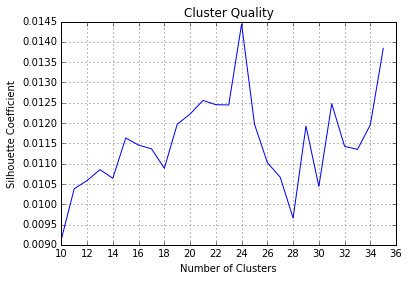

In [68]:
%matplotlib inline 
compare_clusters(lyrics, range(10,36), .8, .0, stop) 

We have a spikes in the silhouette coefficient at 24, so we'll explore that cluster. We'll look at the top ten words from each cluster, as well as the cluster frequency distribution.

Note: despite seeding the algorithm, this function seems to be random, so it may not show a spike at 24 in further runs of this notebook.

In [69]:
num_clusters = 24 
cluster_output = create_clusters(lyrics, tracks, num_clusters, .8, .0)
clus_df = cluster_output[0]
terms = cluster_output[1]
km = cluster_output[2]
print_clusters(lyrics, terms, km)
clus_df['clusters'].value_counts()

Top terms per cluster:

Cluster 0 words: oh, ooh, whoa, way, know, love, go, come, everyth, day, babi, make,

Cluster 1 words: come, home, feel, around, know, time, babi, make, back, hous, never, us,

Cluster 2 words: girl, world, boy, love, like, one, time, make, know, tri, littl, oh,

Cluster 3 words: go, gone, back, whi, bad, could, like, think, know, littl, never, better,

Cluster 4 words: night, tomorrow, darl, last, forev, saturday, lone, way, one, time, love, see,

Cluster 5 words: song, sing, alon, one, night, love, togeth, life, mmm, come, nan, maria,

Cluster 6 words: like, nigga, shit, fuck, yall, niggaz, caus, know, wit, bitch, nan, see,

Cluster 7 words: amor, quiero, si, vida, nunca, vez, tiempo, solo, corazón, voy, porqu, ser,

Cluster 8 words: love, know, say, babi, never, one, heart, make, way, feel, oh, time,

Cluster 9 words: said, believ, look, eye, lie, caus, find, see, could, way, back, know,

Cluster 10 words: away, make, chang, say, beauti, life, hold, see, thin

22    309
12    214
17    170
3     168
7     150
10    149
6     139
8     122
9     121
15     96
20     93
16     76
19     70
0      69
1      62
13     59
2      52
23     52
5      50
4      39
14     32
21     31
18     30
11     30
Name: clusters, dtype: int64

We've used 24 clusters as the final input for our model, but this is something that could be tweaked. We may also find that the clusters aren't altogether meaningful. The silhouette scores were pretty low, indicated a lack of meaningful clusters.

In [84]:
clus_output = clus_df.iloc[:,[1,3]]
clus_output.head()

,clusters,tracks
0,10,TRAWFGF128E0792FE0
1,22,TRBGIPU128F4290454
2,15,TRAWNSM12903CA71FC
3,3,TRADFAQ128F428AC13
4,19,TRAGBPI128E0792998


In [85]:
save_load_path = '../Data/MillionSongSubset/data'
clus_output.to_pickle(save_load_path+'/clusters.pkl')

## Sentiment Analysis

In [7]:
import glob, os
from nltk.tokenize import RegexpTokenizer
import pandas as pd

Sentiment analysis is the process of using natural language processing, text analysis and computational linguistics to identify and extract subjective information in source materials, according to [wikipedia](https://en.wikipedia.org/wiki/Sentiment_analysis). 

Words (unigrams) or groups of words (n-grams) are analyzed and given a positive, negative, and/or neutral score. For example, the word "good" would tend to indicate a positive word while "bad" would indicate a negative word. 

When looking at n-grams this becomes a little more complicated since the words "not good" would indicate a negative designation, but for the scope of this project we'll only be looking at unigrams. We're given the lyrics as an unordered list of words, so we don't have groups of words to analyze.

We perform sentiment analysis using the opinion-lexicon file, which contains most of the positive and negative words used in daily peech and literature. The algorithm goes into each file and compares each word in the lyrics to the words from the positive and negative word list. 

Reference: https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon

First set your directory path to the folder in which the files are stored. Then read in the file of positive and negative words.

In [1]:
mydir = "/Users/AkshaysMacBookPro/Documents/MA755/million_song_dataset/"

In [3]:
# Set your directory here
mydir = "/Users/AkshaysMacBookPro/Documents/MA755/million_song_dataset/"

from nltk.tokenize import RegexpTokenizer

# Make sure you read in all the files for the +ve and -ve list of words
positive_words = open('/Users/AkshaysMacBookPro/Downloads/opinion-lexicon-English/positive-words.txt','r').read()
tokenizer = RegexpTokenizer(r'\w+')
positive_words = tokenizer.tokenize(positive_words)

# Make sure you read in all the files for the +ve and -ve list of words
negative_words = open('/Users/AkshaysMacBookPro/Downloads/opinion-lexicon-English/negative-words.txt','r').read()
tokenizer = RegexpTokenizer(r'\w+')
negative_words = tokenizer.tokenize(negative_words)

Next, we need to create an empty dataframe and navigate to the directory we set.

In [6]:
# Create a dataframe for the variables
import pandas as pd
import os
df = pd.DataFrame({'trackID': 'TRAAAAV128F421A322.txt',
                   'pos_score': 0.1,
                   'neg_score': 0.09,
                   'neu_score': 0.76,
                   'word_count': 103},index=[0])


# Change directory to your directory
os.chdir(mydir)

Then we tokenize the words. This takes a lyrics file and breaks it up into individual words. Each word is tested against the positive and negative word files. If they match, the count is incremented. If a match is not found, the count of neutral words is incremented. We do this for each word in the lyrics file. We also record the length of the sentence, which we'll use to account for varying file lengths.

In [ ]:
#Parse through the entire folder of lyrics files
for file in glob.glob("*.txt"):

    # Read each file
    data_file = open(file).read()

    #Tokenize all words in each file
    tokenizer = RegexpTokenizer(r'\w+')
    data_file = tokenizer.tokenize(data_file)

    #Find the length of each data file
    sentence_len = len(data_file)
    #print(sentence_len)
    print(file)

    #Initialize each variable
    count_neg = 0
    count_pos = 0
    count_neutral = 0

    #Run for loop for each word and check
    for words in data_file:
        if words in negative_words:
            count_neg += 1
        elif words in positive_words:
            count_pos += 1
        else:
            count_neutral += 1

Next we compute sentiment scores for each track. Each category, negative, positive, and neutral, is calculated by dividing the count of words in that category by the length of the sentence. Finally, we write these scores to a file to be used as input for further analysis.

In [ ]:
    # Compute scores
    neg_sentiment = count_neg/sentence_len
    #print(neg_sentiment)
    pos_sentiment = count_pos/sentence_len
    #print(pos_sentiment)
    neu_sentiment = count_neutral/sentence_len
    #print(neu_sentiment)
    #df = df.append([file,pos_sentiment,neg_sentiment,neu_sentiment, sentence_len])

    # Append scores
    df1 = pd.DataFrame({'trackID': [file],
                        'pos_score': [pos_sentiment],
                        'neg_score': [neg_sentiment],
                        'neu_score': [neu_sentiment],
                        'word_count': [sentence_len]} )
    #print(df1)
    df = df.append(df1, ignore_index= True)
    print(file+"appended")

df.to_csv('/Users/AkshaysMacBookPro/Documents/MA755/million_song_dataset/senti_file.csv')

## Create Final Dataframe

Now that we've done our cluster and text analysis using the lyrics, we can pull the data together with the musical data and use a neural network to predict `song_hotttnesss`

First we load the dataframe we created from the million song subset, and get rid of the leading "'b" and trailing "'"

In [86]:
save_load_path = '../Data/MillionSongSubset/data'
project_df = pd.read_pickle(save_load_path+'/project_df.pkl')

# get rid of weird encoding artifact
project_df['track_id'] = project_df['track_id'].map(lambda x: str(x)[2:len(x)+2])


Next we 

In [87]:
clusters = pd.read_pickle(save_load_path+'/clusters.pkl')

# rename tracks to track_id for merge
clusters.columns=['cluster','track_id']
# need to create dummy variables from cluster
dummies = pd.get_dummies(clusters['cluster'])

clusters = pd.concat([clusters, dummies], axis=1)


ml_df = project_df.merge(clusters, on='track_id', how='inner')

ml_df.to_pickle(save_load_path+'/project_mla.pkl')

# need to create dummy variables from cluster

sentiment_df = pd.read_csv(save_load_path+ '/senti_file.csv')
sentiment_df.columns=['row_id','neg_score','neu_score','pos_score','track_id', 'word_count']
nn_df = ml_df.merge(sentiment_df, on='track_id', how='inner')


nn_df.to_csv(save_load_path+'/nn.csv')

## Neural Network

In [1]:
from sknn.mlp import Regressor, Layer

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/Users/AkshaysMacBookPro/Documents/MA755/nn.csv')

In [4]:
df.head()

,artist_id,artist_latitude,artist_location,artist_longitude,song_id,artist_name,title,artist_hotttnesss,key_confidence,mode,...,16,17,18,19,20,row_id,neg_score,neu_score,pos_score,word_count
0,b'ARMJAGH1187FB546F3',35.14968,"b'Memphis, TN'",-90.04892,b'SOCIWDW12A8C13D406',b'The Box Tops',b'Soul Deep',0.417500,0.169,0,...,0,0,0,0,0,2,0.088496,0.694690,0.216814,226
1,b'AR7G5I41187FB4CE6C',NaN,"b'London, England'",NaN,b'SONHOTT12A8C13493C',b'Adam Ant',b'Something Girls',0.454231,0.751,1,...,0,0,0,1,0,4,0.057554,0.769784,0.172662,139
2,b'ARXR32B1187FB57099',NaN,b'',NaN,b'SOFSOCN12A8C143F5D',b'Gob',b'Face the Ashes',0.401724,0.092,1,...,0,0,0,0,0,6,0.087500,0.650000,0.262500,160
3,b'AR8ZCNI1187B9A069B',NaN,b'',NaN,b'SOIAZJW12AB01853F1',b'Planet P Project',b'Pink World',0.332276,0.717,1,...,0,0,0,0,0,12,0.098522,0.689655,0.211823,203
4,b'ARIK43K1187B9AE54C',NaN,"b'Beverly Hills, CA'",NaN,b'SOBONFF12A6D4F84D8',b'Lionel Richie',b'Tonight Will Be Alright',0.553072,0.524,1,...,0,0,0,0,0,20,0.089947,0.703704,0.206349,189


In [5]:
df.tail()

,artist_id,artist_latitude,artist_location,artist_longitude,song_id,artist_name,title,artist_hotttnesss,key_confidence,mode,...,16,17,18,19,20,row_id,neg_score,neu_score,pos_score,word_count
2345,b'AR5S26K1187B9A3141',31.19224,"b'Alexandria, Egypt'",29.88987,b'SOOWVUN12AB0185435',b'Chantal Chamandy',b'Zindegi',0.315026,0.679,0,...,0,0,0,0,0,11018,0.082192,0.660959,0.256849,292
2346,b'AR0ILWV1187FB47CAA',39.75911,"b'Dayton, OH'",-84.19444,b'SOQSJJL12AC46874BC',b'Mouth Of The Architect',b'Harboring An Apparition',0.469056,0.000,1,...,0,0,0,0,0,11023,0.131579,0.776316,0.092105,76
2347,b'ARJGQJD1187B997A00',NaN,"b'Buffalo, NY'",NaN,b'SOFOBSK12A8C1447C4',b'It Dies Today',b'One the road (to Damnation)',0.511577,0.060,1,...,0,0,0,0,0,11024,0.061674,0.832599,0.105727,227
2348,b'AR4C6V01187FB3BAF4',39.55792,b'Portugal',-7.84481,b'SOLXXPY12A67ADABA0',b'Moonspell',b'The Hanged Man',0.499826,0.374,1,...,0,0,0,0,0,11027,0.076190,0.723810,0.200000,210
2349,b'ARYXOV81187B99831D',NaN,b'',NaN,b'SOFAOMI12A6D4FA2D8',b'Seventh Day Slumber',b'Shattered Life',0.509243,0.315,0,...,0,0,0,0,0,11037,0.101382,0.668203,0.230415,217


In [6]:
df.working = df[['artist_hotttnesss','key_confidence','loudness','tempo','neg_score','pos_score','neu_score',
                 '4','9','13','14','16','17','18','19','20']]

In [7]:
df.working.head()

,artist_hotttnesss,key_confidence,loudness,tempo,neg_score,pos_score,neu_score,4,9,13,14,16,17,18,19,20
0,0.417500,0.169,-9.843,121.274,0.088496,0.216814,0.694690,0,0,0,0,0,0,0,0,0
1,0.454231,0.751,-9.013,119.293,0.057554,0.172662,0.769784,0,0,0,0,0,0,0,1,0
2,0.401724,0.092,-4.501,129.738,0.087500,0.262500,0.650000,0,0,1,0,0,0,0,0,0
3,0.332276,0.717,-13.496,86.643,0.098522,0.211823,0.689655,0,0,0,0,0,0,0,0,0
4,0.553072,0.524,-8.346,125.197,0.089947,0.206349,0.703704,0,0,0,0,0,0,0,0,0


In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
df.train, df.test = train_test_split(df.working, test_size=0.2, random_state=0)

In [10]:
df.test.head()

,artist_hotttnesss,key_confidence,loudness,tempo,neg_score,pos_score,neu_score,4,9,13,14,16,17,18,19,20
402,0.598459,0.593,-6.962,133.903,0.003984,0.398406,0.597610,0,0,0,0,0,0,0,0,0
1553,0.305579,0.462,-7.736,57.091,0.266667,0.012121,0.721212,0,0,0,0,0,0,0,0,0
1056,0.578934,0.308,-4.829,89.890,0.093458,0.168224,0.738318,0,0,1,0,0,0,0,0,0
1914,0.417413,0.273,-3.779,147.910,0.082251,0.134199,0.783550,0,0,0,0,0,0,0,0,0
2064,0.517170,0.532,-6.076,61.593,0.125000,0.187500,0.687500,0,0,1,0,0,0,0,0,0


In [11]:
df.train.head()

,artist_hotttnesss,key_confidence,loudness,tempo,neg_score,pos_score,neu_score,4,9,13,14,16,17,18,19,20
342,0.449254,0.585,-8.508,148.642,0.221739,0.017391,0.760870,0,0,0,0,0,0,0,0,0
831,0.547764,0.262,-3.183,158.340,0.155251,0.068493,0.776256,0,0,0,0,0,0,0,0,0
1713,0.389107,0.364,-8.777,167.312,0.052174,0.160870,0.786957,0,0,0,0,0,0,0,0,0
616,0.349483,0.891,-5.059,139.562,0.016216,0.081081,0.902703,1,0,0,0,0,0,0,0,0
2241,0.448840,0.818,-4.620,90.356,0.051471,0.183824,0.764706,0,0,0,0,0,0,0,0,0


In [12]:
len(df.train), len(df.test)

(1880, 470)

In [13]:
df.train.X = df.train.ix[:,'key_confidence':]

In [14]:
df.train.Y = df.train.iloc[:,[0]]

In [15]:
df.train.X.head()

,key_confidence,loudness,tempo,neg_score,pos_score,neu_score,4,9,13,14,16,17,18,19,20
342,0.585,-8.508,148.642,0.221739,0.017391,0.760870,0,0,0,0,0,0,0,0,0
831,0.262,-3.183,158.340,0.155251,0.068493,0.776256,0,0,0,0,0,0,0,0,0
1713,0.364,-8.777,167.312,0.052174,0.160870,0.786957,0,0,0,0,0,0,0,0,0
616,0.891,-5.059,139.562,0.016216,0.081081,0.902703,1,0,0,0,0,0,0,0,0
2241,0.818,-4.620,90.356,0.051471,0.183824,0.764706,0,0,0,0,0,0,0,0,0


In [16]:
df.train.Y.head()

,artist_hotttnesss
342,0.449254
831,0.547764
1713,0.389107
616,0.349483
2241,0.448840


In [17]:
numpyMatrixTrainX = df.train.X.as_matrix()
numpyMatrixTrainY = df.train.Y.as_matrix()

In [18]:
numpyMatrixTrainX

array([[   0.585,   -8.508,  148.642, ...,    0.   ,    0.   ,    0.   ],
       [   0.262,   -3.183,  158.34 , ...,    0.   ,    0.   ,    0.   ],
       [   0.364,   -8.777,  167.312, ...,    0.   ,    0.   ,    0.   ],
       ..., 
       [   0.834,   -4.422,  113.608, ...,    0.   ,    0.   ,    0.   ],
       [   1.   ,  -13.45 ,   71.233, ...,    0.   ,    0.   ,    0.   ],
       [   0.972,   -9.417,  141.271, ...,    0.   ,    0.   ,    0.   ]])

In [19]:
nn = Regressor(
    layers=[
        Layer("Rectifier", units=2),
        Layer("Linear")],
    learning_rate=0.001,
    n_iter=2000)

In [20]:
nn.fit(numpyMatrixTrainX,
       numpyMatrixTrainY)

Regressor(batch_size=1, callback=None, debug=False, dropout_rate=None,
     f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: frozen=False, units=2, name='hidden0'>,
     layers=[<sknn.nn.Layer `Rectifier`: frozen=False, units=2, name='hidden0'>, <sknn.nn.Layer `Linear`: frozen=False, units=1, name='output'>],
     learning_momentum=0.9, learning_rate=0.001, learning_rule='sgd',
     loss_type=None, n_iter=2000, n_stable=10, normalize=None,
     output=<sknn.nn.Layer `Linear`: frozen=False, units=1, name='output'>,
     parameters=None, random_state=None, regularize=None, valid_set=None,
     valid_size=0.0, verbose=None, warning=None, weight_decay=None)

In [21]:
df.test.X = df.test.ix[:,'key_confidence':]
df.test.Y = df.test.iloc[:,[0]]
numpyMatrixTestX = df.test.X.as_matrix()
numpyMatrixTestY = df.test.Y.as_matrix()
numpyMatrixTestX

array([[   0.593,   -6.962,  133.903, ...,    0.   ,    0.   ,    0.   ],
       [   0.462,   -7.736,   57.091, ...,    0.   ,    0.   ,    0.   ],
       [   0.308,   -4.829,   89.89 , ...,    0.   ,    0.   ,    0.   ],
       ..., 
       [   0.814,   -8.647,   83.195, ...,    0.   ,    0.   ,    0.   ],
       [   0.184,   -7.736,  110.255, ...,    0.   ,    0.   ,    0.   ],
       [   0.386,   -9.37 ,  102.677, ...,    0.   ,    0.   ,    0.   ]])

In [22]:
print("Root Mean Squared Error: %.5f"%np.mean((nn.predict(numpyMatrixTestX) - numpyMatrixTestY) ** 2)**(0.5))

Root Mean Squared Error: 0.12410


In [23]:
print('Variance score: %.5f' % nn.score(numpyMatrixTestX, numpyMatrixTestY))

Variance score: -0.00025


In [24]:
print(len(numpyMatrixTestX))
print(len(numpyMatrixTestY))

470
470


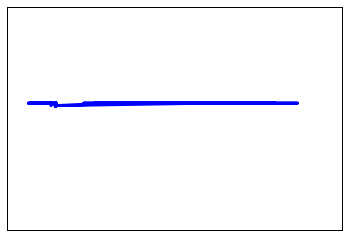

In [30]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
#plt.scatter(numpyMatrixTestX, numpyMatrixTestY,  color='black')
plt.plot(numpyMatrixTestX, nn.predict(numpyMatrixTestX), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Conclusion

We started with the basic variables. There was an RMSE of 0.12451. Then we brought in the sentiment scores. They decreased the RMSE by 0.00012. Last, we brought in the clusters and they increased the RMSE. This wasn't surpising given that the cluster silhouette scores were quite low.

Next steps: given more time we would compare the outcome of the neural network analysis with SVM and ensemble regressors, such as random forest, and bagging/boosting. We also may bring in some of the confidence variables. For example, key has a companion confidence variable that quantifies how confident the data is that they key is correct. 

We would also like to extend this to include more of the lyrics. Since we used the subset we were only left with 2350 records after bringing in the lyrics. However, if we used a greater part of the million songs dataset we might be able to work with more records. This would be particularly important if we were using the confidence variables since many records wouldn't make it into our set.

### References

**TF/IDF**

http://aimotion.blogspot.com/2011/12/machine-learning-with-python-meeting-tf.html

http://stevenloria.com/finding-important-words-in-a-document-using-tf-idf/

**Scikit-Learn Functions**

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html#sklearn.metrics.pairwise.pairwise_distances

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

**Document Clustering Examples**

https://de.dariah.eu/tatom/working_with_text.html

https://github.com/grfiv/haiku_analysis/blob/master/Bag-of-Words%20Analysis%20Haiku%20(unsupervised,%20tf-idf%20%26%20kmeans,%20Silhouette).ipynb

http://brandonrose.org/clustering    

Chapter 5 of the text: Python Data Science Cookbook